<a href="https://colab.research.google.com/github/aditya-shriwastava/ai-notebooks/blob/master/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Docs

## Faster RCNN

### Backbone
> **Input:** Image tensor of shape (C,H,W) in RGB order<br>
> **Output:** Feature map of shape (Cf, Hf, Wf)

1. Pre process Input Image
  1. Normalize the input image with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] 
  2. Rescale the image such that shorter side in 300 pixels.
2. Get Feature map: Pass the pre processed image to resnet backbone
  1. resnet backbone: only conv layers, not fully connected layer at the end
  2. output: feature map of shape (Cf, Hf, Wf)

### RPN (Region Proposal Network)
> **Input:** Feature map of shape (Cf, Hf, Wf), Ground truth bounding boxes<br>
> **Output:** ROIs (i.e. Region of Interests)

1. Pass feature map to 3x3 convolution to reduce depth to 512 while conserving Hf and Wf.
  - stride=1 and padding=1
  - output: feature map of shape (512, Hf, Wf)
2. Pass above output to two 1x1 convolution to get objectness score and bounding box coordinate offset.
  1. Objectness score: (2 x 9, Hf, Wf)
    - Number of anchors: 9
    - (object score + not object score) per anchors: 2
  2. Bbox offset coordinate: (4 x 9, Hf, Wf)
    - Number of anchors: 9
    - Number of param for bbox offset for 1 anchors: 4
3. Calculate all object proposal bbox
  1. Calculate all anchors coordinate.
    - Total number of anchors: 9 x Hf x Wf
  2. Use anchors coordinate and offset coordinates to get object proposals
4. For every object proposal find the corresponding ground truth bbox and calculate IoU (Intersection over Union with it)
5. Filter object proposals to generate training data for training the region proposal network.
  1. Assign negative and positive labels to object proposals based on the following:
    1. Assign positive label to:
      - object proposals with highest IoU with corresponding ground truth bbox.
      - object proposal with IoU higher than 0.7 with corresponding ground truth bbox.
    2. Assign negitave label to:
      - object proposal with IoU less than 0.3 with corresponding ground truth bbox.
  2. Randomly sample 256 object proposals with positive and negative label ratio upto 1:1.
    - If there are fewer than 128 positive samples than pad the mini-batch with negative ones.
6. Calculate the rpn loss (loss = objectness classification loss +  lambda x regression loss) and take one gradient step.
  1. objectness classification loss: negative log likelihood loss
  2. regression loss: smooth L1 loss for positive labels only

### Fast RCNN
> **Input:** Feature map of shape (Cf, Hf, Wf), ROIs, Ground truth bounding box coordinate and label<br>
> **Output:** Object detection bbox and label

1. Project ROIs from image to feature map.
2. Perform ROI pooling on projected feature map to obtain fixed size representation corresponding to each ROIs.
3. Pass the output of above to some FC layers for procession.
4. Pass the output of above to two FC layers:
    1. For object classification.
    2. Bbox regression: Fine tuning ROIs coordinate to obtain detection.
5. Calculate the fast rcnn loss (loss = object classification loss + lambda x regression loss) and take one gradient step.
    1. object classification loss: negative log likelihood loss over K object classes (including background)
    2. regression loss: smooth L1 loss for positive labels only
6. Use NMS to filter out redundant detection.


# Implementation

In [1]:
#@title pip3 install requirements
!pip3 install pytest

## Files

### bbox_utils

#### bbox_utils.py

In [2]:
%%file bbox_utils.py

import torch
import random

"""Formats:
1. minmax: [xmin, ymin, xmax, ymax]
2. minwh: [xmin, ymin, width, height]
3. ctrwh: [xctr, yctr, width, height]
"""
# Inplace version
def minmax_to_minwh_(bbox):
  bbox[2:] = bbox[2:] - bbox[:2] + 1

def minmax_to_ctrwh_(bbox):
  bbox[2:] = bbox[2:] - bbox[:2] + 1
  bbox[:2] += (bbox[2:] - 1)/2 

def minwh_to_minmax_(bbox):
  bbox[2:] = bbox[2:] + bbox[:2] - 1

def ctrwh_to_minmax_(bbox):
  bbox[:2] -= (bbox[2:] - 1)/2
  bbox[2:] = bbox[2:] + bbox[:2] - 1

def minmax_to_minwh_batch_(bboxs):
  bboxs[:,2:] = bboxs[:,2:] - bboxs[:,:2] + 1

def minmax_to_ctrwh_batch_(bboxs):
  bboxs[:,2:] = bboxs[:,2:] - bboxs[:,:2] + 1
  bboxs[:,:2] += (bboxs[:,2:] - 1)/2 

def minwh_to_minmax_batch_(bboxs):
  bboxs[:,2:] = bboxs[:,2:] + bboxs[:,:2] - 1

def ctrwh_to_minmax_batch_(bboxs):
  bboxs[:,:2] -= (bboxs[:,2:] - 1)/2
  bboxs[:,2:] = bboxs[:,2:] + bboxs[:,:2] - 1

# Not Inplace version
def minmax_to_minwh_batch(bboxs):
  bboxs = bboxs.clone()
  bboxs[:,2:] = bboxs[:,2:] - bboxs[:,:2] + 1
  return bboxs

def minmax_to_ctrwh_batch(bboxs):
  bboxs = bboxs.clone()
  bboxs[:,2:] = bboxs[:,2:] - bboxs[:,:2] + 1
  bboxs[:,:2] += (bboxs[:,2:] - 1)/2
  return bboxs 

def minwh_to_minmax_batch(bboxs):
  bboxs = bboxs.clone()
  bboxs[:,2:] = bboxs[:,2:] + bboxs[:,:2] - 1
  return bboxs

def ctrwh_to_minmax_batch(bboxs):
  bboxs = bboxs.clone()
  bboxs[:,:2] -= (bboxs[:,2:] - 1)/2
  bboxs[:,2:] = bboxs[:,2:] + bboxs[:,:2] - 1
  return bboxs

def area(bbox):
  """Returns area of bounding box"""
  if bbox[2] >= bbox[0] and bbox[3] >= bbox[1]:
    area = (bbox[2] - bbox[0] + 1)\
         * (bbox[3] - bbox[1] + 1)
  else:
    area = 0.0
  return area

def area_batch(bboxs):
  """Returns area of bounding boxs"""
  N,_ = bboxs.shape
  areas = torch.zeros(N, dtype=torch.float32)
  isvalid = torch.logical_and(
    (bboxs[:,2] >= bboxs[:,0]),
    (bboxs[:,3] >= bboxs[:,1])
  )

  areas[isvalid] = (bboxs[isvalid,2] - bboxs[isvalid,0] + 1)\
                 * (bboxs[isvalid,3] - bboxs[isvalid,1] + 1)
  return areas

def IoU(bbox1, bbox2):
  """Returns (float) intersection over union between bbox1 and bbox2
  bbox{1,2}: pytorch tensor of shape (4,) in format minmax
  """

  # determine the coordinates of the intersection rectangle
  bbox_int = torch.tensor([
      max(bbox1[0], bbox2[0]),
      max(bbox1[1], bbox2[1]),
      min(bbox1[2], bbox2[2]),
      min(bbox1[3], bbox2[3]) 
  ])
  
  intersection = area(bbox_int)
  union = area(bbox1) + area(bbox2) - intersection
  return intersection/union

def IoU_batch(bboxs1, bboxs2):
  """
  Args:
    bboxs1: tensor of shape (N,4) (i.e. N bboxs)
    bboxs2: tensor of shape (M,4) (i.e. M bboxs)
  Returns:
    tensor of shape (N,M) where i,j entry is
    IoU(bboxs1[i], bboxs2[j])
  """
  N,_ = bboxs1.shape
  M,_ = bboxs2.shape

  # boxes_int.shape = (N,M,4)
  bboxs_int = torch.vstack((
    torch.max(*torch.meshgrid(
        bboxs1[:,0], bboxs2[:,0], indexing='ij'
        )).unsqueeze(0),
    torch.max(*torch.meshgrid(
        bboxs1[:,1], bboxs2[:,1], indexing='ij'
        )).unsqueeze(0),
    torch.min(*torch.meshgrid(
        bboxs1[:,2], bboxs2[:,2], indexing='ij'
        )).unsqueeze(0),
    torch.min(*torch.meshgrid(
        bboxs1[:,3], bboxs2[:,3], indexing='ij'
        )).unsqueeze(0)
  )).permute(1,2,0)

  intersection = area_batch(bboxs_int.view(-1,4)).reshape(N,M)

  union = area_batch(bboxs1).unsqueeze(1).repeat(1,M)\
        + area_batch(bboxs2).unsqueeze(0).repeat(N,1)\
        - intersection
  return intersection/union

def filter_cross_boundary(bboxs, bbox_within):
  """
  Args:
    bboxs: bboxs tensor in minmax format of shape (N,4) to filter.
    bbox_within: bbox tensor in minmax format of shape (4,) within
    which bboxs should be.
  Returns:
    A tensor of shape (M,4) where M<=N representing a subset of
    bboxs which are within bbox_within and corresponding index. 
  """
  N = bboxs.shape[0]
  corner_offset = bboxs - bbox_within
  iswithin = torch.logical_and(
    (corner_offset[:,:2] >= 0).all(axis=1),
    (corner_offset[:,2:] <= 0).all(axis=1)
  )
  return bboxs[iswithin], torch.arange(N)[iswithin]

def filter_IoU(bboxs1, bboxs2, min_IoU=0, max_IoU=1):
  """
  Args:
    bboxs1: bboxs tensor in minmax format of shape (N,4)
    bboxs2: bboxs tensor in minmax format of shape (M,4)
  Returns:
    A tensor of shape (P,4) where P<=N representing a subset of
    bboxs1 such that  min_IoU <= IoU(bboxs[i]) <= max_IoU for i in
    [1,2, ..., N] and corresponding index.
  """
  N = bboxs1.shape[0]
  IoU_max, _ = IoU_batch(bboxs1, bboxs2).max(axis=1)
  iswithin = torch.logical_and(
    (IoU_max >= min_IoU),
    (IoU_max <= max_IoU)
  )
  return bboxs1[iswithin], torch.arange(N)[iswithin]

def bbox_with_max_IoU(bboxs1, bboxs2):
  """
  Args:
    bboxs1: bboxs tensor in minmax format of shape (N,4)
    bboxs2: bboxs tensor in minmax format of shape (M,4)
  Returns:
    A bbox from bboxs1 with max IoU with bboxs2 and
    corresponding index.
  """
  i = IoU_batch(bboxs1, bboxs2).max(axis=1)[0].max(axis=0)[1]
  return bboxs1[i], i

def sample_bboxs(bboxs, max_bboxs):
  N = bboxs.shape[0]
  if N > max_bboxs:
    index = random.sample(range(N),max_bboxs)
    return bboxs[index], torch.tensor(index)
  else:
    return bboxs, torch.arange(N)


Writing bbox_utils.py


#### test_bbox_utils.py

In [3]:
%%file test_bbox_utils.py

import pytest
import torch

from bbox_utils import *

class TestBboxFormateChange:
  @pytest.fixture
  def bbox1(self):
    return torch.tensor([50.,20.,100.,200.])

  def test_minmax_to_minwh(self, bbox1):
    minmax_to_minwh_(bbox1)
    assert abs((bbox1-torch.tensor([50., 20., 51., 181.])).mean()) < 0.01

  def test_minmax_to_ctrwh(self, bbox1):
    minmax_to_ctrwh_(bbox1)
    assert abs((bbox1-torch.tensor([75., 110., 51., 181.])).mean()) < 0.01

  def test_minwh_to_minmax(self, bbox1):
    minwh_to_minmax_(bbox1)
    assert abs((bbox1-torch.tensor([50., 20., 149., 219.])).mean()) < 0.01

  def test_ctrwh_to_minmax(self, bbox1):
    ctrwh_to_minmax_(bbox1)
    assert abs((bbox1-torch.tensor([0.5, -79.5, 99.5, 119.5])).mean()) < 0.01

class TestIoU:
  def test_disjoint(self):
    bbox1 = torch.tensor([0, 0, 49, 49])
    bbox2 = torch.tensor([100, 100, 199, 199])
    assert abs(IoU(bbox1, bbox2)-0) < 0.01 # as intersection in 0

  def test_case2(self):
    bbox1 = torch.tensor([0, 0, 49, 49])
    bbox2 = torch.tensor([0, 0, 99, 99])
    intersection = 50 * 50
    union = 100 * 100
    assert abs(IoU(bbox1, bbox2)-(intersection/union)) < 0.01

  def test_case3(self):
    bbox1 = torch.tensor([75, 25, 124, 74])
    bbox2 = torch.tensor([0, 0, 99, 99])
    intersection = 50 * 25
    union = (100 * 100) + (50 * 25)
    assert abs(IoU(bbox1, bbox2)-(intersection/union)) < 0.01

class TestIoUBatch:
  @pytest.fixture
  def bboxs1(self):
    bboxs1 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [75, 25, 124, 74],
        [75, 75, 124, 124],
        [75, -25, 124, 24]
    ], dtype=torch.float32)
    return bboxs1

  @pytest.fixture
  def bboxs2(self):
    bboxs2 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99]
    ], dtype=torch.float32)
    return bboxs2

  def test(self, bboxs1, bboxs2):
    IoU_12 = IoU_batch(bboxs1, bboxs2)
    IoU_12_expected = torch.tensor([
      [1., 0.25],
      [0.25, 1.],
      [0.11111, 0.14285],
      [0.05263, 0.14285],
      [0.05263, 0.]
    ])

    assert IoU_12.shape == IoU_12_expected.shape
    assert abs((IoU_12-IoU_12_expected).mean()) < 0.01

class TestFilterCrossBoundary:
  @pytest.fixture
  def bboxs(self):
    bboxs = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [-10, 10, 20, 34],
        [10, -10, 20, 34],
        [0, 0, 0, 0],
        [99, 99, 99, 99],
        [0, 0, 199, 199],
    ], dtype=torch.float32)
    return bboxs

  def test(self, bboxs):
    bbox_within = torch.tensor([0, 0, 99, 99])
    iswithin = torch.tensor(
      [True, True, False, False, True, True, False]
    )
    bboxs_, index = filter_cross_boundary(bboxs, bbox_within)
    assert (bboxs_- bboxs[iswithin]).mean() < 0.01
    assert (bboxs[index]- bboxs[iswithin]).mean() < 0.01

class TestFilterIoU:
  @pytest.fixture
  def bboxs1(self):
    bboxs1 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [75, 25, 124, 74],
        [75, 75, 124, 124],
        [75, -25, 124, 24]
    ], dtype=torch.float32)
    return bboxs1

  @pytest.fixture
  def bboxs2(self):
    bboxs2 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99]
    ], dtype=torch.float32)
    return bboxs2

  def test_case1(self, bboxs1, bboxs2):
    bboxs, index = filter_IoU(bboxs1, bboxs2, min_IoU=0, max_IoU=1)
    iswithin = torch.tensor(
      [True, True, True, True, True]
    )
    assert (bboxs - bboxs1[iswithin]).mean() < 0.01
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

  def test_case2(self, bboxs1, bboxs2):
    bboxs, index = filter_IoU(bboxs1, bboxs2, min_IoU=0.1)
    iswithin = torch.tensor(
      [True, True, True, True, False]
    )
    assert (bboxs - bboxs1[iswithin]).mean() < 0.01
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

  def test_case3(self, bboxs1, bboxs2):
    bboxs, index = filter_IoU(bboxs1, bboxs2, max_IoU=0.5)
    iswithin = torch.tensor(
      [False, False, True, True, True]
    )
    assert (bboxs - bboxs1[iswithin]).mean() < 0.01
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

  def test_bbox_with_max_IoU(self, bboxs1, bboxs2):
    bbox, index = bbox_with_max_IoU(bboxs1, bboxs2)
    assert (bbox - bboxs1[0]).mean() < 0.01
    assert index == 0

class TestSampleBboxs:
  @pytest.fixture
  def bboxs(self):
    bboxs = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [-10, 10, 20, 34],
        [10, -10, 20, 34],
        [0, 0, 0, 0],
        [99, 99, 99, 99],
        [0, 0, 199, 199],
    ], dtype=torch.float32)
    return bboxs

  def test_case1(self, bboxs):
    bboxs_, index = sample_bboxs(bboxs, max_bboxs=3)
    assert bboxs_.shape[0] == 3
    assert index.shape[0] == 3

  def test_case2(self, bboxs):
    bboxs_, index = sample_bboxs(bboxs, max_bboxs=10)
    assert bboxs_.shape[0] == bboxs.shape[0]
    assert index.shape[0] == bboxs.shape[0]

Writing test_bbox_utils.py


#### Run tests

In [4]:
!python -m pytest test_bbox_utils.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-3.6.4, py-1.11.0, pluggy-0.7.1
rootdir: /content, inifile:
plugins: typeguard-2.7.1
collected 15 items                                                             

test_bbox_utils.py ...............                                       [100%]

========================== 15 passed in 6.32 seconds ===========================


### voc_utils

In [5]:
%%file voc_utils.py

import torch

voc_labels = ("background",
  "aeroplane", "bicycle", "bird", "boat","bottle",
  "bus", "car", "cat", "chair", "cow",
  "diningtable", "dog", "horse", "motorbike", "person",
  "pottedplant", "sheep", "sofa", "train", "tvmonitor"
)

voc_label_to_id = {k: v+1 for v, k in enumerate(voc_labels)}
voc_label_to_id['background'] = 0

def get_bboxs_and_labels(meta):
  objects = meta['annotation']['object']
  bboxs = []
  labels = []
  ids = []
  for object_ in objects:
    labels.append(object_['name'][0])
    ids.append(voc_label_to_id[labels[-1]])
    xmin = int(object_['bndbox']['xmin'][0])
    ymin = int(object_['bndbox']['ymin'][0])
    xmax = int(object_['bndbox']['xmax'][0])
    ymax = int(object_['bndbox']['ymax'][0])
    bboxs.append([xmin, ymin, xmax, ymax])
  return torch.tensor(bboxs, dtype=torch.float32), labels, ids

Writing voc_utils.py


## main

In [6]:
#@title imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from bbox_utils import *
from voc_utils import *

%reload_ext autoreload
%autoreload 2

In [7]:
#@title Load VOC data
train_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='train', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

val_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='val', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets


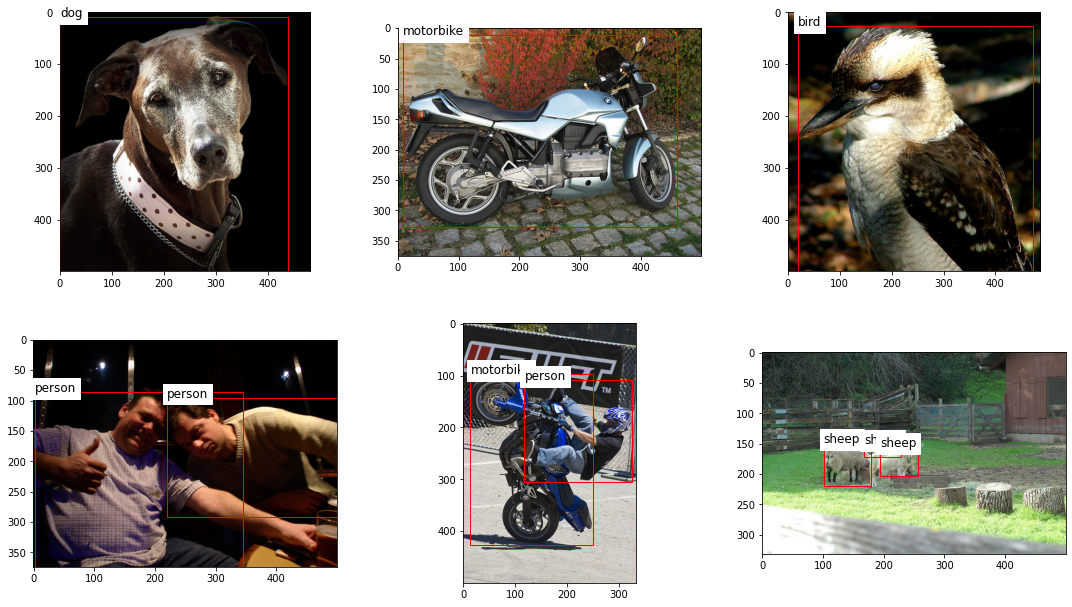

In [8]:
#@title Show sample train data
def disp(img, bboxs, labels, ax=None):
  img = torchvision.transforms.ToPILImage()(img)
  if ax is None:
    fig, ax = plt.subplots()
  ax.imshow(img)
  for bbox, label in zip(bboxs, labels):
    bbox = np.copy(bbox)
    minmax_to_minwh_(bbox)
    ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none'))
    ax.text(bbox[0], bbox[1], label, fontsize = 12, color='black', backgroundcolor='white')
  if ax is None:
    plt.show()

fig, axarr = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
for index, (img, meta) in enumerate(train_loader):
  i = index // 3
  j = index - (i * 3)
  bboxs, labels, ids = get_bboxs_and_labels(meta)
  disp(img[0], bboxs, labels, ax=axarr[i,j])
  if index == 5:
    break
plt.show()

### Models

#### RPN

In [21]:
class RPN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lower_dim_mapping = nn.Sequential(
        nn.Conv2d(1024, 512, 3, stride=1, padding=1),
        nn.ReLU()
    )
    self.objectness_score = nn.Conv2d(512, 9*2, 1, stride=1, padding=0)
    self.rois_offset= nn.Conv2d(512, 9*4, 1, stride=1, padding=0)
    
  def forward(self, feature_map, bboxs_gt, image_shape):
    """ TODO: This will just be forward pass no loss calculation.
    Args:
      image: tensor of shape (1, C, H, W).
      feature_map: tensor of shape (1, 2048, Hf, Wf).
      bboxs_gt: tensor of shape (M,4) in minmax format representing
        M ground truth bboxs on the image corresponding to the given
        feature_map.
    """
    _,_, H, W = image_shape
    _, _, Hf, Wf = feature_map.shape

    feature_map = self.lower_dim_mapping(feature_map) 
    objectness_score = self.objectness_score(feature_map)\
      .view(9*2,Hf,Wf).permute((1,2,0)).reshape(-1,2)
    rois_offset = self.rois_offset(feature_map)\
      .view(9*4,Hf,Wf).permute((1,2,0)).reshape(-1,4)

    anchors = self.get_anchors(Hf,Wf)

    rois = self.get_bboxs(rois_offset, anchors)

    rois = ctrwh_to_minmax_batch(rois)

    rois, index = filter_cross_boundary(
      rois,
      torch.tensor([0, 0, H, W], dtype=torch.float32)
    )

    rois_positive, index_ = filter_IoU(rois, bboxs_gt, min_IoU=0.7)
    index_positive = index[index_]

    roi_max_IoU , index_ = bbox_with_max_IoU(rois, bboxs_gt)
    rois_positive = torch.vstack((
        rois_positive,
        roi_max_IoU
    ))
    index_positive = torch.hstack((index_positive, index_))

    rois_negative, index_ = filter_IoU(rois, bboxs_gt, max_IoU=0.3)
    index_negative = index[index_]

    rois_positive, index_ =\
      sample_bboxs(
        rois_positive,
        max_bboxs = 128
      )
    index_positive = index_positive[index_]

    rois_negative , index_ =\
      sample_bboxs(
        rois_negative,
        max_bboxs = 256 - rois_positive.shape[0]
      )
    index_negative = index_negative[index_]

    _, index_ = IoU_batch(rois_positive, bboxs_gt).max(axis=1)
    bboxs_gt_positive = bboxs_gt[index_]

    bboxs_gt_positive = minmax_to_ctrwh_batch(
      bboxs_gt_positive
    )

    bboxs_gt_positive_offset = self.get_bboxs_offset(
      bboxs_gt_positive,
      anchors[index_positive]
    )

    reg_loss = self.get_reg_loss(
      rois_offset[index_positive],
      bboxs_gt_positive_offset
    )

    cls_loss = self.get_cls_loss(
      objectness_score[index_positive],
      objectness_score[index_negative]
    )

    return rois[index_positive], reg_loss, cls_loss

  def get_losses(self):
    """
    TODO:
      - Call this for training.
      - This will call the forward pass
    """
    pass

  def get_reg_loss(
      self,
      rois_positive_offsets,
      bboxs_gt_positive_offset):
    return 0

  def get_cls_loss(
      self,
      objectness_score_positive,
      objectness_score_negative):
    return 0

  def get_bboxs(self, bboxs_offset, anchors):
    """Reff https://arxiv.org/pdf/1506.01497.pdf eq2
    Args:
      bboxs_offset: tensor of shape (N,4) representing offset of bboxs in
        ctrwh format form anchors.
      anchors: tensor of shape (N,4) representing anchors in ctrwh format
    Returns:
      A tensor of shape (N,4) representing bboxs
    """
    bboxs = torch.zeros_like(bboxs_offset)

    bboxs[:,0] = anchors[:,0] + (bboxs_offset[:,0] * anchors[:,2])
    bboxs[:,1] = anchors[:,1] + (bboxs_offset[:,1] * anchors[:,3])
    bboxs[:,2] = anchors[:,2] * torch.exp(bboxs_offset[:,2])
    bboxs[:,3] = anchors[:,3] * torch.exp(bboxs_offset[:,3])
    return bboxs

  def get_bboxs_offset(self, bboxs, anchors):
    """Reff https://arxiv.org/pdf/1506.01497.pdf eq2
    Args:
      bboxs: tensor of shape (N,4) representing bboxs in ctrwh format.
      anchors: tensor of shape (N,4) representing anchors in ctrwh format
    Returns:
      A tensor of shape (N,4) representing bboxs_offset
    """
    bboxs_offset = torch.zeros_like(bboxs)

    bboxs_offset[:,0] = (bboxs[:,0] - anchors[:,0]) / anchors[:,2]
    bboxs_offset[:,1] = (bboxs[:,1] - anchors[:,1]) / anchors[:,3]
    bboxs_offset[:,2] = torch.log(bboxs[:,2] / anchors[:,2])
    bboxs_offset[:,3] = torch.log(bboxs[:,3] / anchors[:,3])
    return bboxs_offset

  def get_anchors(self, Hf, Wf):
    """
    Returns:
      A tensor of shape (Hf*Wf*9,4) representing 9 anchors in ctrwh format at
      each pixel position.
    """
    stride = 10
    anchors = self.get_base_anchors().view(-1)\
      .unsqueeze(0).repeat(Wf,1)\
      .unsqueeze(0).repeat(Hf,1,1)\
      .view(Hf,Wf,9,4)

    shift_x = (torch.arange(0, Wf) * stride).repeat(Hf,1)\
      .repeat(9,1,1).permute(1,2,0)
    shift_y = (torch.arange(0, Hf) * stride).unsqueeze(1).repeat(1,Wf)\
      .repeat(9,1,1).permute(1,2,0)

    anchors[:,:,:,0] += shift_x
    anchors[:,:,:,1] += shift_y

    return anchors.reshape(-1,4)

  def get_base_anchors(self):
    """
    Returns:
      A tensor of shape (9,4) representing 9 anchors in ctrwh format centered
      at (7.5,7.5) with ratios (i.e. width/height) [2:1, 1:1, 1:2],and sizes 
      (i.e. width * height) [64^2, 128^2, 256^2].
    """
    base_size=16
    ratios = torch.tensor([0.5, 1.0, 2.0])
    scales = torch.tensor([4.0, 8.0, 16.0])

    # base_anchors(1,4) in ctrwh format
    base_anchors = torch.tensor([[
      (base_size-1)/2,
      (base_size-1)/2,
      base_size,
      base_size
    ]])

    # Apply ratios to base_anchors(1,4) to generate base_anchors(3,4)
    size = base_anchors[0,2] * base_anchors[0,3]
    base_anchors = base_anchors.repeat(3,1)
    heights = torch.sqrt(size * ratios)
    widths = heights/ratios
    base_anchors[:,2] = heights
    base_anchors[:,3] = widths

    # Apply scale to base_anchors(3,4) to generate base_anchors(9,4)
    base_anchors = base_anchors.repeat(1,3).view(9,4)
    base_anchors[:,2:4] *= scales.repeat(3).view(9,1).repeat(1,2)

    return torch.round(base_anchors)

#### Fast RCNN

In [10]:
class FastRCNN(nn.Module):
  def __init__(self):
    pass

#### Faster RCNN

In [11]:
class FasterRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet50 = torchvision.models.resnet50(pretrained=True)
    self.backbone = nn.Sequential(
      self.resnet50.conv1,
      self.resnet50.bn1,
      self.resnet50.relu,
      self.resnet50.maxpool,
      self.resnet50.layer1,
      self.resnet50.layer2,
      self.resnet50.layer3
    )
    self.rpn = RPN()
    self.fast_rcnn = FastRCNN()
    
  def forward(self, img):
    return self.backbone(img)

### Training

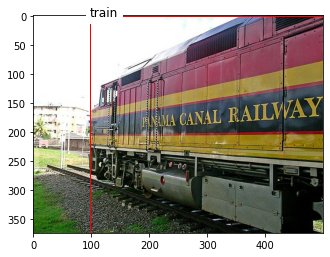

In [22]:
def preprocess(img, bboxs):
  # 1. Resize the Image 
  _, _, H, W = img.shape
  img = torchvision.transforms.Resize(300)(img)
  _, _, H_, W_ = img.shape

  # 2. Resize the bboxs according to image resize
  bboxs = bboxs * torch.tensor([W_/W, H_/H, W_/W, H_/H], dtype=torch.float32)

  # 3. Normalize the the image
  normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  img = normalize(img)
  return img, bboxs

# Training
for img, meta in train_loader:
  bboxs, labels, ids = get_bboxs_and_labels(meta)
  disp(img[0], bboxs, labels)
  img, bboxs = preprocess(img, bboxs)
  faster_rcnn = FasterRCNN()
  rpn = RPN()
  feature_map = faster_rcnn(img)
  rpn(feature_map, bboxs, img.shape)
  break

### Inference